<a href="https://colab.research.google.com/github/rybak97/free_courses/blob/main/Seasonal_Volatility_for_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on https://www.datacamp.com/tutorial/stocks-significance-testing-p-hacking

simple script to download data from yahoo finance

In [1]:
import pandas as pd
import datetime as dt
import yfinance as yf  # jeśli nie masz: pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1️⃣ Zakres dat
start = dt.datetime(1993, 1, 1)
end = dt.datetime.today()

# 2️⃣ Pobranie danych z Yahoo Finance
df = yf.download("SPY", start=start, end=end)

# 3️⃣ Formatowanie: zostawiamy tylko datę i cenę zamknięcia
df = df.reset_index()
df["date"] = df["Date"].dt.strftime("%d-%b-%y")
df["close"] = df["Close"].astype(float)

# 4️⃣ Zapis pliku CSV w żądanym formacie
out = df[["date", "close"]]
out.to_csv("spy_date_close.csv", index=False, header=True, float_format="%.2f")

print(f"Zapisano {len(out)} wierszy do pliku spy_date_close.csv")
print(out.head(5))

/tmp/ipython-input-946378120.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("SPY", start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Zapisano 8253 wierszy do pliku spy_date_close.csv
Price        date      close
Ticker                      
0       29-Jan-93  24.313030
1       01-Feb-93  24.485958
2       02-Feb-93  24.537836
3       03-Feb-93  24.797228
4       04-Feb-93  24.900974


In [2]:
#Daily S&P500 data from 1993==>
df = pd.read_csv('/content/spy_date_close.csv', parse_dates=True)

#view raw S&P500 data
df.head()

,date,close
0,29-Jan-93,24.31
1,01-Feb-93,24.49
2,02-Feb-93,24.54
3,03-Feb-93,24.80
4,04-Feb-93,24.90


In [3]:
#To model returns we will use daily % change [alternate we can take natural log]
daily_ret = df['close'].pct_change()
#drop the 1st value - nan
daily_ret.dropna(inplace=True)
#daily %change
daily_ret.head()

,close
1,0.007404
2,0.002042
3,0.010595
4,0.004032
5,-0.000803


In [4]:
daily_ret_df = pd.DataFrame({
    'date': df['date'].iloc[1:],
    'daily_return': daily_ret
})
display(daily_ret_df.head())

,date,daily_return
1,01-Feb-93,0.007404
2,02-Feb-93,0.002042
3,03-Feb-93,0.010595
4,04-Feb-93,0.004032
5,05-Feb-93,-0.000803


To get mnthly_annu, we first use the 'resample' method on our daily returns. Resample allows us to change the frequency of the data periods.

The second thing we need to do is decide how we want to arrive at this new monthly figure, for example, we could sum the daily values together, multiply them, etc. For our analysis, we want some measure of volatility and standard deviation works well, so we will append std() to our resampled data to get monthly volatility.

The final step is to annualize this figure. We do this simply by multiplying by the square root of 12, with 12 being the number of periods (months) in a year. This gives us our annualized monthly volatility values that we require.

date
1993-02-28    0.027951
1993-03-31    0.024936
1993-04-30    0.025752
1993-05-31    0.024629
1993-06-30    0.020597
Freq: ME, Name: daily_return, dtype: float64


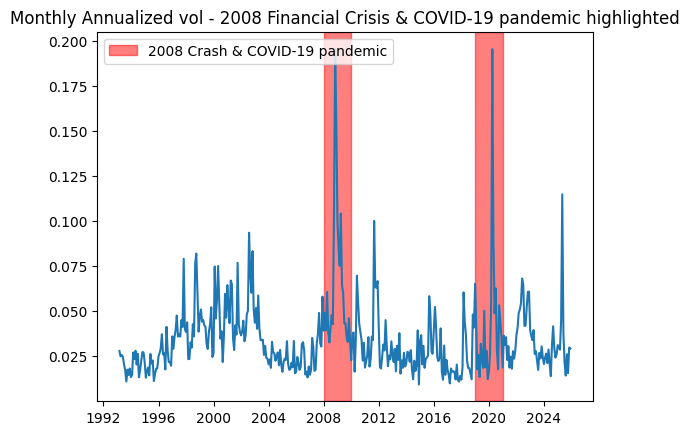

In [10]:
# The 'date' column is already the index and is in datetime format, so these lines are no longer needed.
# daily_ret_df['date'] = pd.to_datetime(daily_ret_df['date'], format='%d-%b-%y')
# daily_ret_df = daily_ret_df.set_index('date')

mnthly_annu = daily_ret_df['daily_return'].resample('ME').std()* np.sqrt(12)

print(mnthly_annu.head())
#we can see major market events show up in the volatility
plt.plot(mnthly_annu)
plt.axvspan('2008','2010',color='r',alpha=.5)
plt.axvspan('2019','2021',color='r',alpha=.5)
plt.title('Monthly Annualized vol - 2008 Financial Crisis & COVID-19 pandemic highlighted')
labs = mpatches.Patch(color='red',alpha=.5, label="2008 Crash & COVID-19 pandemic")
plt.legend(handles=[labs])

In [20]:
#for each year rank each month based on volatility lowest=1 Highest=12
ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()

#average the ranks over all years for each month
final = ranked.groupby(ranked.index.month).mean()

final.describe()


,daily_return
count,12.000000
mean,6.470723
std,0.654102
min,5.625000
25%,6.007576
50%,6.424242
75%,6.851089
max,7.666667


In [21]:
final

,daily_return
date,
1,6.781250
2,6.636364
3,7.666667
4,7.060606
5,6.666667
6,6.060606
7,5.666667
8,6.030303
9,6.212121


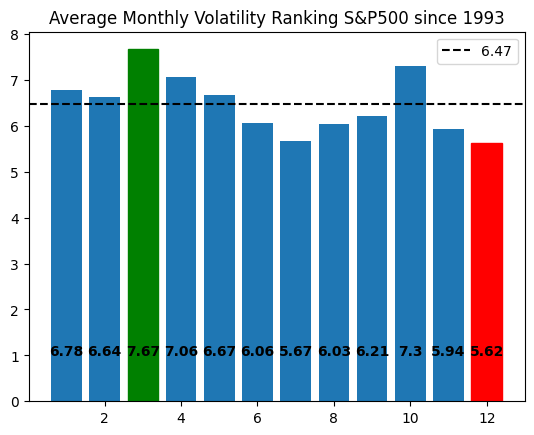

In [29]:
#plot results for ranked s&p 500 volatility
#clearly March has the highest AMVR
#and December has the lowest
#mean of 6.47 is plotted

b_plot = plt.bar(x=final.index, height=final, width=0.8) # Made bars thicker with width=0.8
b_plot[2].set_color('g')
b_plot[11].set_color('r')
for i,v in enumerate(round(final,2)):
    plt.text(i+1, 1, str(v), color='black', ha='center', fontweight='bold')
plt.axhline(final.mean(),ls='--',color='k',label=round(final.mean(),2))
plt.title('Average Monthly Volatility Ranking S&P500 since 1993')

plt.legend()
plt.show()

In [44]:
#take abs value move from the mean
#we see March and Dec are the biggest abs moves

fin = abs(final - final.mean())
print(fin.sort_values())


date
2     0.165641
5     0.195944
9     0.258602
1     0.310527
6     0.410117
8     0.440420
11    0.531329
4     0.589883
7     0.804056
10    0.832307
12    0.845723
3     1.195944
Name: daily_return, dtype: float64
